# Exploratory Data Analysis in ARTchives

## Imports

In [34]:
# rdflib
import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS
from SPARQLWrapper import SPARQLWrapper, JSON

# utils
import ssl, os.path, json, requests , ast
from collections import defaultdict
import itertools

# spacy
import spacy
import random
from spacy.util import minibatch, compounding
from pathlib import Path
from spacy.training import Example
from spacy.tokens import Doc

# python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# data proc 
import pandas as pd
import numpy as np
from apyori import apriori

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules

#csv
import csv 

# graph data
import networkx as nx
from networkx.algorithms import bipartite

# data viz
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# maps
from ipywidgets import HTML
from ipyleaflet import Map, Marker, Popup, LayersControl, AwesomeIcon

#networks
from pyvis import network as net

## Utils

In [58]:
def wikidata_reconciliation(query, q_class=None):
    "Find Wikidata QID for a query string"
    params = {
        'action': 'wbsearchentities',
        'format': 'json',
        'language': 'en',
        'search': query
    }
    # query wd API
    API_WD = "https://www.wikidata.org/w/api.php"
    r = requests.get(API_WD, params = params).json()

    # double check if the entity belongs to the right class
    if 'search' in r and len(r['search']) >= 1:
        if q_class:
            query_string = """ASK {wd:"""+r['search'][0]['title']+""" a <https://www.wikidata.org/entity/"""+q_class+""">. }"""
            res = return_sparql_query_results(query_string)
            print("\nRES", query, query_string, res)
            if res["boolean"] == 'true':
                return [ r['search'][0]['title'] , 'class_match']
            else:
                return [ r['search'][0]['title'] , 'no_class_match']
        else:
            return [ r['search'][0]['title'] , 'no_class_given']
    else:
        return 'not matched'
    
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

## Analysis of art historians' relations according to places of education and activity

### Get the list of historians, names, and biographies from ARTchives.

In [59]:
artists_query = """
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wdt: <http://www.wikidata.org/wiki/Property:>
    SELECT ?historian (sample(?names) as ?name) ?bio
    WHERE { 
        ?collection wdt:P170 ?historian . 
        ?historian rdfs:label ?names. 
        OPTIONAL{?historian <http://purl.org/dc/terms/description> ?bio}
    }
    GROUP BY ?historian ?name ?bio"""

art_historians = []

try :
    art_sparql = SPARQLWrapper("http://artchives.fondazionezeri.unibo.it/sparql")
    art_sparql.setQuery(artists_query)
    art_sparql.setReturnFormat(JSON)
    results = art_sparql.query().convert()
    for result in results["results"]["bindings"]:
        historian = {}
        historian["uri"] = result["historian"]["value"]
        historian["name"] = result["name"]["value"]
        if "bio" in result:
            historian["bio"] = result["bio"]["value"]
        art_historians.append(historian)
except Exception as e:
    print(e) 
    


### Get historians' places of education and activity from Wikidata

In [60]:
ssl._create_default_https_context = ssl._create_unverified_context
wikidata_endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"

if os.path.isfile("historian_places.json"):
    f = open('historian_places.json')
    results = json.load(f)
else:
    historians_list = ' '.join(['<'+art_dict["uri"]+'>' for art_dict in art_historians])
    eduplace_query = """ 
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    SELECT DISTINCT ?historian ?workplace ?workplace_label ?coordinates1 ?eduplace ?eduplace_label ?coordinates2
    WHERE {
            VALUES ?historian {"""+historians_list+"""} . 
            
            optional {
                ?historian wdt:P108 ?workplace . 
                ?workplace rdfs:label ?workplace_label ; 
                            wdt:P625 ?coordinates1; 
                            wdt:P31 ?type .
                FILTER (langMatches(lang(?workplace_label), "EN")) 
                ?type rdfs:label ?type_label . 
                FILTER (langMatches(lang(?type_label), "EN"))
                }
            optional {
                ?historian wdt:P69 ?eduplace . 
                ?eduplace rdfs:label ?eduplace_label ;
                            wdt:P625 ?coordinates2; 
                            wdt:P31 ?type . 
                FILTER (langMatches(lang(?eduplace_label), "EN")) 
                ?type rdfs:label ?type_label . 
                FILTER (langMatches(lang(?type_label), "EN")) 
                }
            } 
    GROUP BY ?historian ?workplace ?workplace_label ?coordinates1 ?eduplace ?eduplace_label ?coordinates2 
    """
    try :
        sparql_wd = SPARQLWrapper(wikidata_endpoint)
        sparql_wd.setQuery(eduplace_query)
        sparql_wd.setReturnFormat(JSON)
        results = sparql_wd.query().convert()

        #with open('historian_places.json', 'w') as f:
        #    json.dump(results, f, indent=4)
    except Exception as e:
        print(e)

HTTP Error 429: Too Many Requests


### Include results in a graph

In [40]:
# create an empty Graph
g = rdflib.ConjunctiveGraph()

# bind namespaces
wd = Namespace("http://www.wikidata.org/entity/") # remember that a prefix matches a URI until the last slash (or hashtag #)
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")
rdfs = Namespace ("http://www.w3.org/2000/01/rdf-schema#")

for result in results["results"]["bindings"]:
    historian_uri = result["historian"]["value"]
    name = [art_dict["name"] for art_dict in art_historians if art_dict["uri"] == historian_uri][0]
    g.add(( URIRef(historian_uri) , RDFS.label , Literal(name) ))
    if "workplace" in result: 
        workplace = result["workplace"]["value"]
        if "workplace_label" in result and "coordinates1" in result: 
            workplace_label = result["workplace_label"]["value"]
            work_coord = result["coordinates1"]["value"][6:-1].split(" ")
            g.add(( URIRef(historian_uri) , URIRef(wdt.P108) , URIRef(workplace) ))
            g.add(( URIRef(workplace) , RDFS.label , Literal(workplace_label) ))
            g.add(( URIRef(workplace) , RDFS.comment , Literal("institution") ))
            g.add(( URIRef(workplace) , URIRef(wdt.P625) , Literal(work_coord) ))
    if "eduplace" in result: 
        eduplace = result["eduplace"]["value"]
        if "eduplace_label" in result and "coordinates2" in result: 
            eduplace_label = result["eduplace_label"]["value"]
            eduplace_coord = result["coordinates2"]["value"][6:-1].split(" ")
            g.add(( URIRef(historian_uri) , URIRef(wdt.P69) , URIRef(eduplace) ))
            g.add(( URIRef(eduplace) , RDFS.label , Literal(eduplace_label) ))
            g.add(( URIRef(eduplace) , RDFS.comment , Literal("institution") ))
            g.add(( URIRef(eduplace) , URIRef(wdt.P625) , Literal(eduplace_coord) ))

### Retrain Spacy to recognize specific organizations.

In [41]:
# train spacy with new data

ner=nlp.get_pipe("ner")
TRAIN_DATA = [
    ("Working at Villa I Tatti.", {"entities": [(11, 24, "ORG")]})
]

for _, annotations in TRAIN_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])
        
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# TRAINING THE MODEL
with nlp.disable_pipes(*unaffected_pipes):

  # Training for 30 iterations
  for iteration in range(30):

    # shuufling examples  before every iteration
    random.shuffle(TRAIN_DATA)
    losses = {}
    # batch up the examples using spaCy's minibatch
    batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        texts, annotations = zip(*batch)
        doc = nlp.make_doc(texts[0])
        example = Example.from_dict(doc, annotations[0])
        nlp.update(
                    [example],
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses
                )
        print("Losses", losses)

Losses {'ner': 1.4529261790051384}
Losses {'ner': 0.24286107765613574}
Losses {'ner': 0.24713702510076047}
Losses {'ner': 0.6596266081323847}
Losses {'ner': 1.1959147878460572}
Losses {'ner': 3.47141141238626}
Losses {'ner': 0.19532141112803816}
Losses {'ner': 0.002683775602891711}
Losses {'ner': 0.0009612613725036401}
Losses {'ner': 0.00019214466979272014}
Losses {'ner': 0.4712310468519023}
Losses {'ner': 0.00028999877526975743}
Losses {'ner': 0.02715925006976505}
Losses {'ner': 0.0007832295736732754}
Losses {'ner': 1.489041690966135e-06}
Losses {'ner': 0.00017557130870500336}
Losses {'ner': 0.0004553010421582378}
Losses {'ner': 0.02674086442445977}
Losses {'ner': 6.6435328028654375e-06}
Losses {'ner': 0.0008506748198799797}
Losses {'ner': 3.3252826871424697e-07}
Losses {'ner': 0.0002514583861976196}
Losses {'ner': 4.224807755977843e-06}
Losses {'ner': 0.00023011470504794132}
Losses {'ner': 3.705451650164599e-07}
Losses {'ner': 1.1780564208073856e-07}
Losses {'ner': 0.0608305956606298

### Get places and organizations mentioned in the biographies of historians from ARTchives. Reconcile Named Entities with Wikidata.

In [61]:
artchives_places = []
for historian in art_historians:
    if "bio" in historian:
        doc = nlp(historian["bio"])
        #print('\n' , historian["name"])
        for ent in doc.ents:
            if ent.label_ == 'GPE' or ent.label_ == 'ORG':
                #print(ent)
                place = {}
                place["historian"] = historian["uri"]
                place["name"] = ent.text
                place["type"] = ent.label_
                ent_text = ent.text[4:] if (ent.text).startswith("the") else ent.text
                print(ent_text)
                qid = wikidata_reconciliation(ent_text)
                place["qid"] = qid[0] if qid != 'not matched' else "not found"
                print(place)
                artchives_places.append(place)
                
#print(artchives_places)

Federico Zeri
{'historian': 'http://www.wikidata.org/entity/Q1089074', 'name': 'Federico Zeri', 'type': 'ORG', 'qid': 'Q1089074'}
Rome
{'historian': 'http://www.wikidata.org/entity/Q1089074', 'name': 'Rome', 'type': 'GPE', 'qid': 'Q220'}
Mentana
{'historian': 'http://www.wikidata.org/entity/Q1089074', 'name': 'Mentana', 'type': 'GPE', 'qid': 'Q242942'}
University of Rome
{'historian': 'http://www.wikidata.org/entity/Q1089074', 'name': 'the University of Rome', 'type': 'ORG', 'qid': 'Q209344'}
Pietro Toesca
{'historian': 'http://www.wikidata.org/entity/Q1089074', 'name': 'Pietro Toesca', 'type': 'ORG', 'qid': 'Q253864'}
Jacopino del Conte
{'historian': 'http://www.wikidata.org/entity/Q1089074', 'name': 'Jacopino del Conte', 'type': 'ORG', 'qid': 'Q2538308'}
Ministry for Cultural Heritage
{'historian': 'http://www.wikidata.org/entity/Q1089074', 'name': 'the Ministry for Cultural Heritage', 'type': 'ORG', 'qid': 'not found'}
Galleria Spada
{'historian': 'http://www.wikidata.org/entity/Q10

{'historian': 'http://www.wikidata.org/entity/Q55453618', 'name': 'the Federico Zeri Foundation', 'type': 'ORG', 'qid': 'Q23687322'}
Zeri Foundation
{'historian': 'http://www.wikidata.org/entity/Q55453618', 'name': 'the Zeri Foundation', 'type': 'ORG', 'qid': 'not found'}
Rome
{'historian': 'http://www.wikidata.org/entity/Q55453618', 'name': 'Rome', 'type': 'GPE', 'qid': 'Q220'}
Anna Ottani Cavina
{'historian': 'http://www.wikidata.org/entity/Q55453618', 'name': 'Anna Ottani Cavina', 'type': 'ORG', 'qid': 'Q61481008'}
Federico Zeri
{'historian': 'http://www.wikidata.org/entity/Q55453618', 'name': 'Federico Zeri', 'type': 'ORG', 'qid': 'Q1089074'}
Alba (Cuneo
{'historian': 'http://www.wikidata.org/entity/Q1361667', 'name': 'Alba (Cuneo', 'type': 'ORG', 'qid': 'not found'}
University of Turin
{'historian': 'http://www.wikidata.org/entity/Q1361667', 'name': 'the University of Turin', 'type': 'ORG', 'qid': 'Q499911'}
Pietro Toesca
{'historian': 'http://www.wikidata.org/entity/Q1361667', 'n

{'historian': 'http://www.wikidata.org/entity/Q1715096', 'name': 'the German Kunsthistorisches Institut', 'type': 'ORG', 'qid': 'not found'}
Middeldorf
{'historian': 'http://www.wikidata.org/entity/Q1715096', 'name': 'Middeldorf', 'type': 'ORG', 'qid': 'Q106120041'}
Middeldorf
{'historian': 'http://www.wikidata.org/entity/Q1715096', 'name': 'Middeldorf', 'type': 'ORG', 'qid': 'Q106120041'}
Middeldorf
{'historian': 'http://www.wikidata.org/entity/Q1715096', 'name': 'Middeldorf', 'type': 'ORG', 'qid': 'Q106120041'}
Renaissance
{'historian': 'http://www.wikidata.org/entity/Q1715096', 'name': 'Renaissance', 'type': 'ORG', 'qid': 'Q4692'}
Ulrich Middeldorf
{'historian': 'http://www.wikidata.org/entity/Q1715096', 'name': 'Ulrich Middeldorf', 'type': 'ORG', 'qid': 'Q1715096'}
Universities of Giessen
{'historian': 'http://www.wikidata.org/entity/Q1715096', 'name': 'the Universities of Giessen', 'type': 'ORG', 'qid': 'Q30293594'}
Munich
{'historian': 'http://www.wikidata.org/entity/Q1715096', '

{'historian': 'http://www.wikidata.org/entity/Q3057287', 'name': 'Rome', 'type': 'GPE', 'qid': 'Q220'}
Renaissance
{'historian': 'http://www.wikidata.org/entity/Q3057287', 'name': 'Renaissance', 'type': 'ORG', 'qid': 'Q4692'}
Steinmann’s
{'historian': 'http://www.wikidata.org/entity/Q3057287', 'name': 'Steinmann’s', 'type': 'ORG', 'qid': 'not found'}
Art Museum
{'historian': 'http://www.wikidata.org/entity/Q3057287', 'name': 'the Art Museum', 'type': 'ORG', 'qid': 'Q207694'}
Schwerin
{'historian': 'http://www.wikidata.org/entity/Q3057287', 'name': 'Schwerin', 'type': 'GPE', 'qid': 'Q1709'}
Rome
{'historian': 'http://www.wikidata.org/entity/Q3057287', 'name': 'Rome', 'type': 'GPE', 'qid': 'Q220'}
Henriette Hertz
{'historian': 'http://www.wikidata.org/entity/Q3057287', 'name': 'Henriette Hertz', 'type': 'ORG', 'qid': 'Q103498'}
Art History
{'historian': 'http://www.wikidata.org/entity/Q3057287', 'name': 'Art History', 'type': 'ORG', 'qid': 'Q50637'}
Rome
{'historian': 'http://www.wikidat

{'historian': 'http://www.wikidata.org/entity/Q1296486', 'name': 'Hamburg', 'type': 'GPE', 'qid': 'Q1055'}
Jacopo Vignola's
{'historian': 'http://www.wikidata.org/entity/Q1296486', 'name': "Jacopo Vignola's", 'type': 'ORG', 'qid': 'not found'}
Kunsthistorisches Institut
{'historian': 'http://www.wikidata.org/entity/Q1296486', 'name': 'the Kunsthistorisches Institut', 'type': 'ORG', 'qid': 'Q872398'}
Hilde Bauer
{'historian': 'http://www.wikidata.org/entity/Q1296486', 'name': 'Hilde Bauer', 'type': 'ORG', 'qid': 'Q99208488'}
Germany
{'historian': 'http://www.wikidata.org/entity/Q1296486', 'name': 'Germany', 'type': 'GPE', 'qid': 'Q183'}
International Commission for Monuments
{'historian': 'http://www.wikidata.org/entity/Q1296486', 'name': 'the International Commission for Monuments', 'type': 'ORG', 'qid': 'not found'}
Munich
{'historian': 'http://www.wikidata.org/entity/Q1296486', 'name': 'Munich', 'type': 'GPE', 'qid': 'Q1726'}
Zentralinstitut
{'historian': 'http://www.wikidata.org/ent

{'historian': 'http://www.wikidata.org/entity/Q61913691', 'name': 'Vertova', 'type': 'ORG', 'qid': 'Q101747'}
Settignano
{'historian': 'http://www.wikidata.org/entity/Q61913691', 'name': 'Settignano', 'type': 'GPE', 'qid': 'Q942605'}
Villa I Tatti
{'historian': 'http://www.wikidata.org/entity/Q61913691', 'name': 'Villa I Tatti', 'type': 'ORG', 'qid': 'Q3558578'}
Nicky Mariano
{'historian': 'http://www.wikidata.org/entity/Q61913691', 'name': 'Nicky Mariano', 'type': 'ORG', 'qid': 'Q62017972'}
London
{'historian': 'http://www.wikidata.org/entity/Q61913691', 'name': 'London', 'type': 'GPE', 'qid': 'Q84'}
Nicolson
{'historian': 'http://www.wikidata.org/entity/Q61913691', 'name': 'Nicolson', 'type': 'ORG', 'qid': 'Q21511687'}
Drawings  Specialist
{'historian': 'http://www.wikidata.org/entity/Q61913691', 'name': 'Drawings  Specialist', 'type': 'ORG', 'qid': 'not found'}
Christie’s International
{'historian': 'http://www.wikidata.org/entity/Q61913691', 'name': 'Christie’s International', 'typ

{'historian': 'http://www.wikidata.org/entity/Q85761254', 'name': 'Villa Poggio', 'type': 'ORG', 'qid': 'Q4012761'}
Caiano
{'historian': 'http://www.wikidata.org/entity/Q85761254', 'name': 'Caiano', 'type': 'ORG', 'qid': 'Q18484321'}
Villa I Tatti
{'historian': 'http://www.wikidata.org/entity/Q85761254', 'name': 'Villa I Tatti', 'type': 'ORG', 'qid': 'Q3558578'}
The Harvard University Center for Italian Renaissance Studies
{'historian': 'http://www.wikidata.org/entity/Q85761254', 'name': 'The Harvard University Center for Italian Renaissance Studies', 'type': 'ORG', 'qid': 'Q3558578'}
Munich
{'historian': 'http://www.wikidata.org/entity/Q85761254', 'name': 'Munich', 'type': 'GPE', 'qid': 'Q1726'}
Bibliotheca Hertziana
{'historian': 'http://www.wikidata.org/entity/Q85761254', 'name': 'the Bibliotheca Hertziana', 'type': 'ORG', 'qid': 'Q339759'}
Rome
{'historian': 'http://www.wikidata.org/entity/Q85761254', 'name': 'Rome', 'type': 'GPE', 'qid': 'Q220'}
Visiting Scholar
{'historian': 'htt

{'historian': 'http://www.wikidata.org/entity/Q60185', 'name': 'the Kunsthistorisches Institut', 'type': 'ORG', 'qid': 'Q872398'}
Warburg
{'historian': 'http://www.wikidata.org/entity/Q60185', 'name': 'Warburg', 'type': 'GPE', 'qid': 'Q968'}
Warburg
{'historian': 'http://www.wikidata.org/entity/Q60185', 'name': 'Warburg', 'type': 'GPE', 'qid': 'Q968'}
Medical Faculty of the University of Berlin
{'historian': 'http://www.wikidata.org/entity/Q60185', 'name': 'the Medical Faculty of the University of Berlin', 'type': 'ORG', 'qid': 'not found'}
Florence
{'historian': 'http://www.wikidata.org/entity/Q60185', 'name': 'Florence', 'type': 'ORG', 'qid': 'Q2044'}
Warburg
{'historian': 'http://www.wikidata.org/entity/Q60185', 'name': 'Warburg', 'type': 'GPE', 'qid': 'Q968'}
Adolph Ferdinand Hertz
{'historian': 'http://www.wikidata.org/entity/Q60185', 'name': 'Adolph Ferdinand Hertz', 'type': 'ORG', 'qid': 'Q365337'}
Hamburg
{'historian': 'http://www.wikidata.org/entity/Q60185', 'name': 'Hamburg',

{'historian': 'http://www.wikidata.org/entity/Q3051533', 'name': 'Magdalen College', 'type': 'ORG', 'qid': 'Q81162'}
Oxford
{'historian': 'http://www.wikidata.org/entity/Q3051533', 'name': 'Oxford', 'type': 'ORG', 'qid': 'Q34433'}
Reynolds
{'historian': 'http://www.wikidata.org/entity/Q3051533', 'name': 'Reynolds', 'type': 'ORG', 'qid': 'Q194402'}
Greece
{'historian': 'http://www.wikidata.org/entity/Q3051533', 'name': 'Greece', 'type': 'GPE', 'qid': 'Q41'}
Greece
{'historian': 'http://www.wikidata.org/entity/Q3051533', 'name': 'Greece', 'type': 'GPE', 'qid': 'Q41'}
Egypt
{'historian': 'http://www.wikidata.org/entity/Q3051533', 'name': 'Egypt', 'type': 'GPE', 'qid': 'Q79'}
MBE
{'historian': 'http://www.wikidata.org/entity/Q3051533', 'name': 'MBE', 'type': 'ORG', 'qid': 'Q1992656'}
Monuments and Fine Arts Commission
{'historian': 'http://www.wikidata.org/entity/Q3051533', 'name': 'the Monuments and Fine Arts Commission', 'type': 'ORG', 'qid': 'not found'}
Holland
{'historian': 'http://ww

Disambiguate place names that appear also in the name of the historian.

### Find coordinates in Wikidata. 

In [62]:
entities_list = []
for historian in artchives_places:
    historian["historian_name"] =  [hist["name"] for hist in art_historians if hist["uri"] == historian["historian"]][0]
    if historian["name"] not in historian["historian_name"] and historian["qid"] != 'not found':
        entities_list.append("<http://www.wikidata.org/entity/"+historian["qid"]+">")

for group_entities in chunks(entities_list, 100):
    entities_tbr = " ".join(list(set(group_entities)))  
    wd_coordinates = """
        PREFIX wdt: <http://www.wikidata.org/prop/direct/>
        SELECT DISTINCT ?place ?place_label ?coord (group_concat(?type_label ; separator="; ") as ?label) 
        WHERE {
            VALUES ?place {"""+entities_tbr+"""} . 
            ?place wdt:P625 ?coord.
            OPTIONAL {?place rdfs:label ?place_label . FILTER (langMatches(lang(?place_label), "EN")) .} 
            OPTIONAL {?place wdt:P31 ?type . ?type rdfs:label ?type_label . FILTER (langMatches(lang(?type_label), "EN"))} 
            
            } 
            group by ?place ?place_label ?coord ?label
        """

    # set the endpoint 
    sparql_wd = SPARQLWrapper(wikidata_endpoint)
    # set the query
    sparql_wd.setQuery(wd_coordinates)
    # set the returned format
    sparql_wd.setReturnFormat(JSON)
    # get the results
    results = sparql_wd.query().convert()

    loc_list = ['country', 'city', 'village', 'capital', 'state', 'region', 'municipality', 'county', 'frazione', 'comune', 'city-state', 'enclave']

    for result in results["results"]["bindings"]:
        loc = ''
        place = result["place"]["value"]
        place_name = result["place_label"]["value"] if "place_label" in result else "no name"
        print(place, place_name)
        coord = result["coord"]["value"][6:-1].split(" ")
        type_label = result["label"]["value"].split("; ")[0] if "label" in result else "no name"
        type_label_list = type_label.split(" ")
        check =  any(item in loc_list for item in type_label_list)
        if check:
            loc = "geolocation"
        else:
            loc = 'institution'

        g.add(( URIRef(place) , RDFS.label , Literal(place_name) ))
        g.add(( URIRef(place) , wdt.P625 , Literal(coord) ))
        g.add(( URIRef(place) , RDFS.comment , Literal(loc) ))     

http://www.wikidata.org/entity/Q90 Paris
http://www.wikidata.org/entity/Q1726 Munich
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q2044 Florence
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q3757699 Galleria Spada
http://www.wikidata.org/entity/Q30 United States of America
http://www.wikidata.org/entity/Q30 United States
http://www.wikidata.org/entity/Q30 United States of America
http://www.wikidata.org/entity/Q220 Rome
http://www.wikidata.org/entity/Q65 Los Angeles
http://www.wikidata.org/entity/Q65 Los Angeles
http://www.wikidata.org/entity/Q5092 Baltimore
http://www.wikidata.org/entity/Q5092 Baltimore
http://www.wikidata.org/entity/Q5092 Baltimore
http://www.wikidata.org/entity/Q239303 Art Institute of Chicago
http://www.wikidata.org/entity/Q239303 Art Institute of Chicago
http://www.wikidata.org/entity/Q820887 University of Florence
http://www.wikidata.org/entity/Q90 Paris
http://www.w

http://www.wikidata.org/entity/Q4012761 Poggio Reale
http://www.wikidata.org/entity/Q90 Paris
http://www.wikidata.org/entity/Q1726 Munich
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q2044 Florence
http://www.wikidata.org/entity/Q1614068 United State Schools for Fine and Applied Arts
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q490 Milan
http://www.wikidata.org/entity/Q30 United States of America
http://www.wikidata.org/entity/Q30 United States
http://www.wikidata.org/entity/Q30 United States of America
http://www.wikidata.org/entity/Q220 Rome
http://www.wikidata.org/entity/Q49210 New York University
http://www.wikidata.org/entity/Q6602 Strasbourg
http://www.wikidata.org/entity/Q90 Paris
http://www.wikidata.org/entity/Q2093794 Vassar College
http://www.wikidata.org/entity/Q38 Italy
http://www.wikidata.org/entity/Q18484321 Caiano
http://www.wikidata.org/entity/Q339759 Bibliotheca Hertziana – Max Planck Institute of Art History
htt

### Link new places to historians

In [63]:
for historian in artchives_places:
    qid = URIRef("http://www.wikidata.org/entity/"+historian["qid"]) if historian["qid"] != 'not found' else None
    if qid and (qid, RDFS.label, None) in g:
        g.add(( URIRef(historian["historian"]) , wdt.P7153 , qid )) # P7153 significant place
        
g.serialize(destination='RQ1.nq', format='nquads') 

### Convert to JSON.

In [64]:
data_RQ1 = []

g = rdflib.ConjunctiveGraph()

# parse a local RDF file by specifying the format
result = g.parse("RQ1.nq", format='nquads')

qres = g.query(
    """
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    SELECT DISTINCT ?placeqid ?placename ?coords ?placetype ?historianuri ?historianlabel 
       WHERE {
          ?placeqid wdt:P625 ?coords .
          OPTIONAL {?placeqid rdfs:label ?placename ; rdfs:comment ?placetype .}
          ?historianuri (wdt:P7153 | wdt:P108 | wdt:P69) ?placeqid ; rdfs:label ?historianlabel
       }""")

unique_places = list(set([row[0] for row in qres]))

for place in unique_places:
    place_dict = defaultdict(list)
    for row in qres:
        if row[0] == place:
            place_dict["QID"] = str(row[0])
            place_dict["label"] = str(row[1])
            place_dict["coords"] = str(row[2])
            place_dict["type"] = str(row[3])
            place_dict["historians"]. append(( str(row[4]),str(row[5])  ))
    place_dict = dict(place_dict)
    data_RQ1.append(place_dict)

In [65]:
data_RQ1_hist = []
unique_historians = list(set(row[4] for row in qres))
for hist in unique_historians:
    hist_dict = defaultdict(list)
    for row in qres:
        if row[4] == hist:
            hist_dict["historian"] = str(row[4])
            hist_dict["label"] = str(row[5])
            loc_type = " (loc)" if str(row[3]) == "geolocation" else " (inst)"
            place = "United States (loc)" if str(row[1]) == "United States of America" else str(row[1])+loc_type
            hist_dict["places"].append(place)
    hist_dict["places"] = list(set(hist_dict["places"]))
    hist_dict = dict(hist_dict)
    data_RQ1_hist.append(hist_dict)

In [66]:
with open('RQ1.json', 'w') as f:
    json.dump(data_RQ1, f, indent=4)
with open('RQ1_hist.json', 'w') as f:
    json.dump(data_RQ1_hist, f, indent=4)

### Map of the places of art historians

In [67]:
center = (41.080684, -30.683374)
m = Map(center=center, zoom=3, close_popup_on_click=False)

if os.path.isfile("RQ1.json"):
    f = open('RQ1.json')
    data_RQ1 = json.load(f)
    

for place in data_RQ1:
    historians = [list(item) for item in set(tuple(row) for row in place["historians"])]
    names = [ hist[1] for hist in historians ]
    namelist = "; ".join(names)
    coords = ast.literal_eval(place["coords"])
    if place["type"] == "geolocation":
        icon2 = AwesomeIcon(
        name = "map-marker",
        marker_color='blue',
        icon_color='white',
        spin=False
        )
        marker = Marker(icon = icon2, location=(coords[1], coords[0]))
        m.add_layer(marker)
    else:
        icon2 = AwesomeIcon(
        name = "bank",
        marker_color='green',
        icon_color='white',
        spin=False
            )
        marker = Marker(icon = icon2, location=(coords[1], coords[0]))
        m.add_layer(marker)
    
    message = HTML()
    marker.popup = message
    message.description = ""
    message.value = "<b>" + place["label"] + "</b>" + "<br/>" + namelist

m

Map(center=[41.080684, -30.683374], close_popup_on_click=False, controls=(ZoomControl(options=['position', 'zo…

### Map of the distribution of art historians

In [68]:
df = pd.read_json("RQ1.json")
df.head()

QID                       label  \
0  http://www.wikidata.org/entity/Q1068063  National Gallery of Canada   
1    http://www.wikidata.org/entity/Q20103                      Assisi   
2  http://www.wikidata.org/entity/Q1446181              Hunter College   
3  http://www.wikidata.org/entity/Q3757699              Galleria Spada   
4   http://www.wikidata.org/entity/Q210081          Walters Art Museum   

                              coords         type  \
0        ['-75.698386', '45.429434']  institution   
1               ['12.6175', '43.07']  geolocation   
2        ['-73.964741', '40.768538']  institution   
3   ['12.471944444', '41.894194444']  institution   
4  ['-76.616111111', '39.296666666']  institution   

                                          historians  
0  [[http://www.wikidata.org/entity/Q3051533, Ell...  
1  [[http://www.wikidata.org/entity/Q18935222, We...  
2  [[http://www.wikidata.org/entity/Q457739, Leo ...  
3  [[http://www.wikidata.org/entity/Q1089074, Fed...  
4  [[http://www.wikidata.org/entity/Q1089074, Fed...

In [69]:
df[['long','lat']] = df['coords'].str.strip('[]').str.split(', ', expand=True)
#df['list'] = df['historians'].apply(lambda txt: ','.join(map(str, txt ) ) )
df['people'] = [ "; ".join([e[1] for e in i]) for i in df['historians'].tolist() ] 
df['count'] = df.historians.apply(len)
df['long'] = df['long'].str.replace("'",'').astype(float)
df['lat'] = df['lat'].str.replace("'",'').astype(float)
tok = 'pk.eyJ1IjoibWFyaWxlbmFkYXF1aW5vIiwiYSI6ImNpeWx6MjZ3dTAwMjkzMmpyZGR2ejVqZHoifQ.AjYdPJPgptZiqrLSrrHSxQ'
px.set_mapbox_access_token(tok)
fig = px.scatter_mapbox(df, lat="lat", lon="long", size_max=40, color="type",
    size="count", hover_data=["people"], hover_name='label', zoom=2, title='Distribution of historians')
fig.update_layout( mapbox_accesstoken=tok)
#fig.show()

### Relations between art historians based on the network of places and institutions

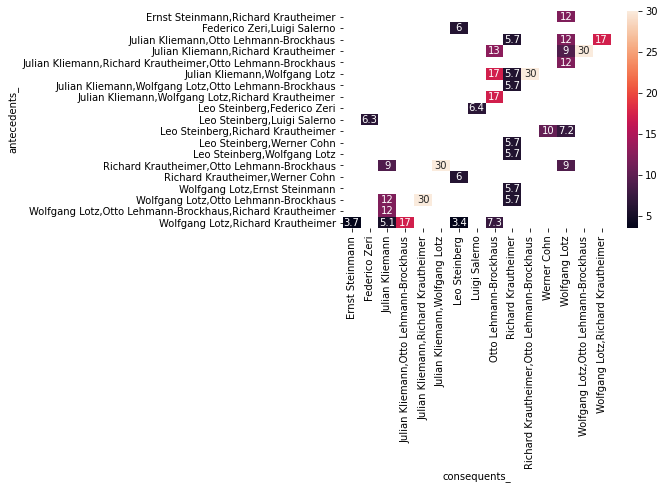

In [71]:
people = df['people'].tolist()
people = [ list(set([el]))  if ';' not in el else list(set([i for i in el.split('; ')])) for el in people]
te = TransactionEncoder()
te_ary = te.fit(people).transform(people)
dfrel = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets_historians = fpgrowth(dfrel, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_itemsets_historians, metric="confidence", min_threshold=0.1)
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()
# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', columns = 'consequents_', values= 'lift')
# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

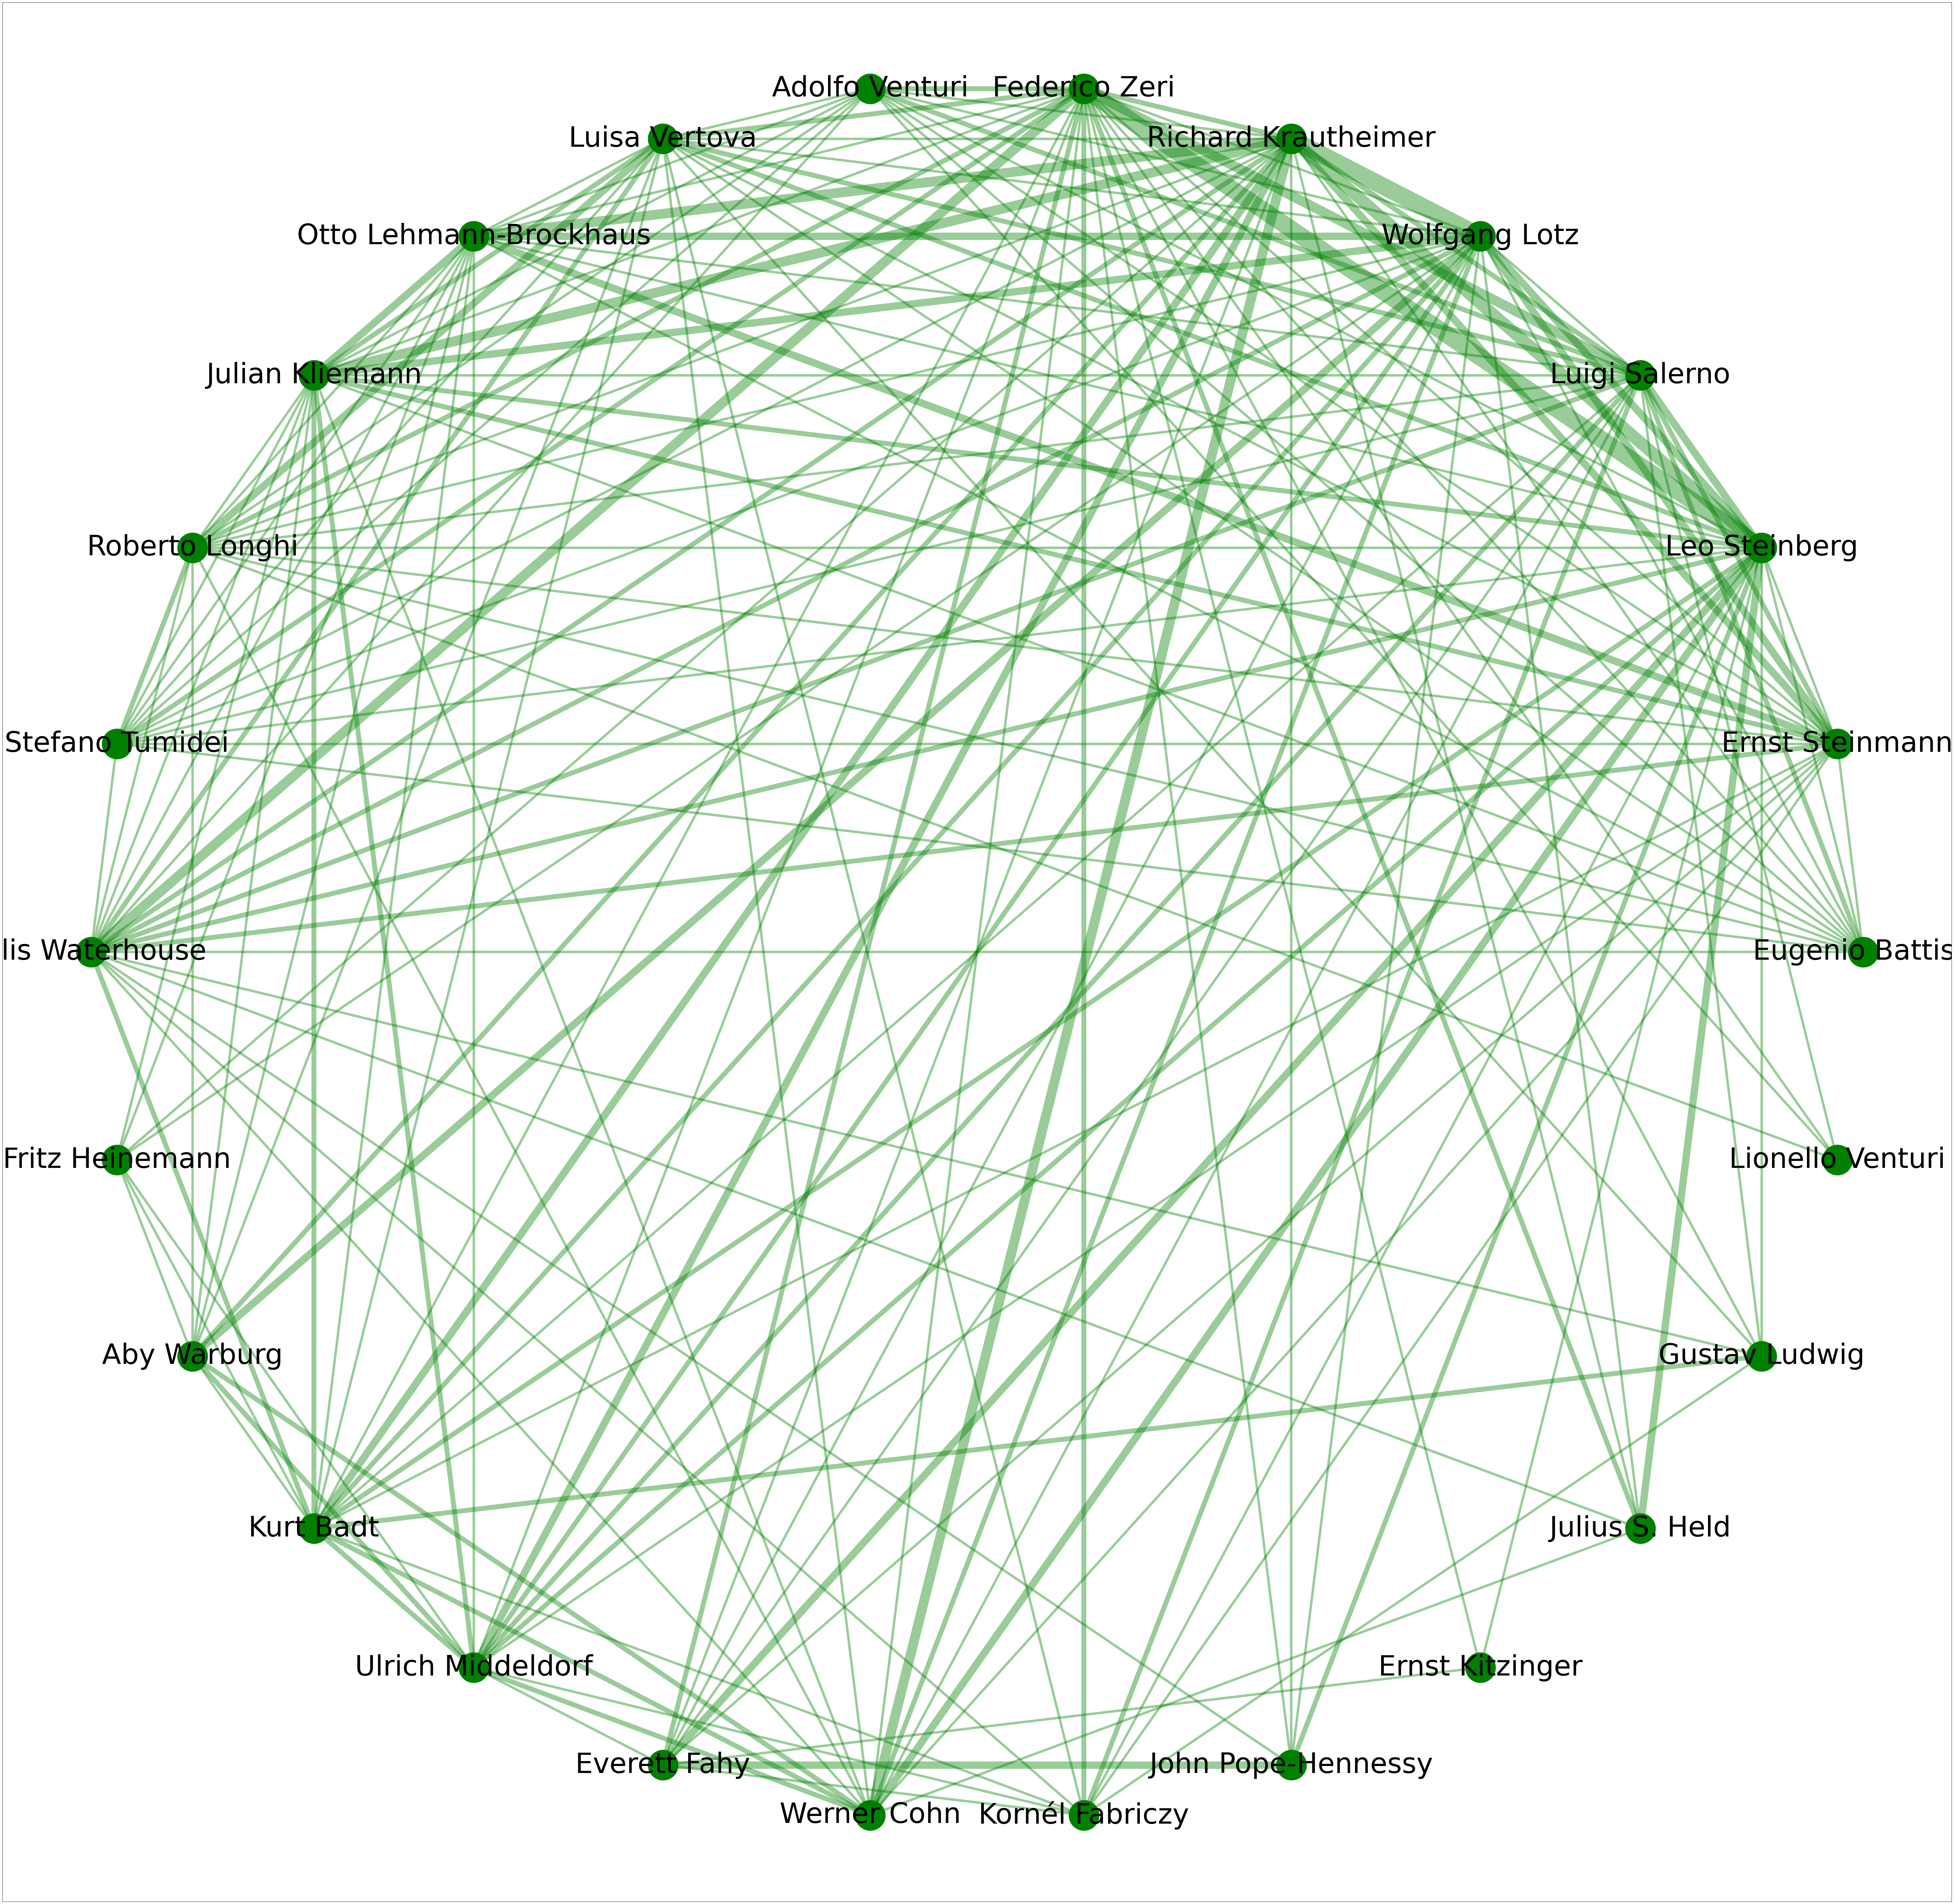

In [72]:
unique_names = set(itertools.chain.from_iterable(people))

# Get all combinations of pairs
all_pairs = list(itertools.combinations(unique_names, 2))

# Create the dictionary
hp_relations = [ (pair[0], pair[1], len([x for x in people if set(pair) <= set(x)]) ) for pair in all_pairs]
hp_relations = [ pair for pair in hp_relations if pair[2] >0]
#print(hp_relations)

G = nx.Graph()
G.add_weighted_edges_from(hp_relations)

plt.figure(1,figsize=(100,100))

pos=nx.circular_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx_nodes(G,pos,node_color='green',node_size=7500)
 
#3. If you want, add labels to the nodes
labels = {}
for node_name in unique_names:
    labels[str(node_name)] = str(node_name)



nx.draw_networkx_labels(G,pos,labels,font_size=80)

all_weights = []
#4 a. Iterate through the graph nodes to gather all the weights
for (node1,node2,data) in G.edges(data=True):
    all_weights.append(data['weight']) #we'll use this when determining edge thickness

#4 b. Get unique weights
unique_weights = list(set(all_weights))

#4 c. Plot the edges - one by one!
for weight in unique_weights:
    weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
    nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,edge_color='g', width=weight*7.0, alpha= 0.4)



#### Graph density

In [73]:
d = nx.density(G)
print(d)

0.5538461538461539


## Analysis of art historians' relations according to shared reasearch topics

### Extraction of the art historical periods registered in ARTchives

In [18]:
#! pip install rdflib
import rdflib
from rdflib import Namespace , Literal , URIRef
from rdflib.namespace import RDF , RDFS

# create an empty Graph
g = rdflib.ConjunctiveGraph()

# parse a local RDF file by specifying the format
result = g.parse("artchives.nq", format='nquads') #Desktop/dhdk_epds/resources/

# bind the uncommon namespaces
wd = Namespace("http://www.wikidata.org/entity/") # remember that a prefix matches a URI until the last slash (or hashtag #)
wdt = Namespace("http://www.wikidata.org/prop/direct/")
art = Namespace("https://w3id.org/artchives/")
rdfs = Namespace ("http://www.w3.org/2000/01/")

# Get the list of art historians in our graph "g"
arthistorians_list = set()
arthistorians_names = list()

# iterate over the triples in the graph
for s,p,o in g.triples(( None, wdt.P170, None)):
    for subj, prop, obj in g.triples((o, RDFS.label, None )):# people "o" are the creator "wdt.P170" of a collection "s"
        if "wikidata.org/entity/" in str(o):           # look for the substring to filter wikidata entities only
            arthistorians_list.add('<' + str(o) + '>')
            if obj.strip() not in arthistorians_names:
                arthistorians_names.append(obj.strip())
                arthistorians_names.append('<' + str(o) + '>')  # remember to transform them in strings! 
    
print(arthistorians_list)
print(arthistorians_names)



{'<http://www.wikidata.org/entity/Q995470>', '<http://www.wikidata.org/entity/Q457739>', '<http://www.wikidata.org/entity/Q537874>', '<http://www.wikidata.org/entity/Q18935222>', '<http://www.wikidata.org/entity/Q1712683>', '<http://www.wikidata.org/entity/Q1641821>', '<http://www.wikidata.org/entity/Q6700132>', '<http://www.wikidata.org/entity/Q60185>', '<http://www.wikidata.org/entity/Q1089074>', '<http://www.wikidata.org/entity/Q85761254>', '<http://www.wikidata.org/entity/Q1629748>', '<http://www.wikidata.org/entity/Q19997512>', '<http://www.wikidata.org/entity/Q1373290>', '<http://www.wikidata.org/entity/Q55453618>', '<http://www.wikidata.org/entity/Q90407>', '<http://www.wikidata.org/entity/Q1271052>', '<http://www.wikidata.org/entity/Q1296486>', '<http://www.wikidata.org/entity/Q1715096>', '<http://www.wikidata.org/entity/Q88907>', '<http://www.wikidata.org/entity/Q61913691>', '<http://www.wikidata.org/entity/Q3057287>', '<http://www.wikidata.org/entity/Q41616785>', '<http://www

### Extract the main subjects of the collections

In [19]:
coll_related = {}
for coll,p,hist in g.triples(( None, wdt.P170, None)):
    for historian, proper, hist_name in g.triples((hist, RDFS.label, None)):     # people "o" are the creator "wdt.P170" of a collection "s"
        for collection, pr, coll_name in g.triples(( coll, RDFS.label, None)):   
            for col, prop, content in g.triples((coll, wdt.P921, None)):     
                for cont, pro, content_label in g.triples(( content, RDFS.label, None)): 
                    if "wikidata.org/entity/" in str(content):    
                        key = tuple([hist_name.strip(), '<' + str(hist) + '>'])
                        value = '<' + str(content) + '>'
                        if key not in coll_related.keys():
                            coll_related[key] = set([value])
                        else:
                            coll_related[key].add(value)



### Extract the art historical periods related to the collections

In [20]:
query_periods = g.query(
        """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
        SELECT ?hist_label ?hist ?period (SAMPLE(?label) AS ?period_label) 
        WHERE {?coll <https://w3id.org/artchives/hasSubjectPeriod> ?period ; rdfs:label ?coll_label 
        . ?coll wdt:P170 ?hist . ?hist rdfs:label ?hist_label .
        ?period rdfs:label ?label . 
        }
        GROUP BY ?period ?label ?hist ?hist_label 
        ORDER BY ?period""")
    


periods = set()
period_dict = {}

for result in query_periods:
    #print(result)
    hist = tuple([result[0].strip(), '<' + str(result[1])+ '>'])
    period = '<' + str(result[2].strip()) + '>'
    #print(period)
    if hist not in period_dict.keys():
        period_dict[hist] = set([period])
    else:
        period_dict[hist].add(period)


period_dict[('Roberto Longhi', '<http://www.wikidata.org/entity/Q1361667>')] = {'<http://www.wikidata.org/entity/Q6927>', '<http://www.wikidata.org/entity/Q7017>', '<http://www.wikidata.org/entity/Q7034>', '<http://www.wikidata.org/entity/Q7018>', '<http://www.wikidata.org/entity/Q4692>', '<http://www.wikidata.org/entity/Q7016>'}
for k,v in period_dict.items():
    print(k, v)
    for value in v:
        periods.add(str(value)) 

('Ernst Kitzinger', '<http://www.wikidata.org/entity/Q88907>') {'<http://www.wikidata.org/entity/Q12554>', '<http://www.wikidata.org/entity/Q211884>', '<http://www.wikidata.org/entity/Q429811>'}
('Federico Zeri', '<http://www.wikidata.org/entity/Q1089074>') {'<http://www.wikidata.org/entity/Q37853>', '<http://www.wikidata.org/entity/Q4692>', '<http://www.wikidata.org/entity/Q7016>', '<http://www.wikidata.org/entity/Q12554>', '<http://www.wikidata.org/entity/Q7017>', '<http://www.wikidata.org/entity/Q7018>', '<http://www.wikidata.org/entity/Q131808>'}
('Otto Lehmann-Brockhaus', '<http://www.wikidata.org/entity/Q1641821>') {'<http://www.wikidata.org/entity/Q12554>'}
('Werner Cohn', '<http://www.wikidata.org/entity/Q18935222>') {'<http://www.wikidata.org/entity/Q12554>', '<http://www.wikidata.org/entity/Q4692>'}
('Kurt Badt', '<http://www.wikidata.org/entity/Q1629748>') {'<http://www.wikidata.org/entity/Q37853>', '<http://www.wikidata.org/entity/Q12554>', '<http://www.wikidata.org/entity/

### Define art historical periods' temporal extension through Wikidata

In [21]:
period_list = ' '.join(periods)
period_res = """
            PREFIX wdt: <http://www.wikidata.org/prop/direct/>
            PREFIX wd: <http://www.wikidata.org/entity/>
            SELECT DISTINCT ?period ?period_label ?startdate ?enddate
            WHERE {
                VALUES ?period {"""+period_list+"""} . 
                ?period wdt:P580 ?startdate ; wdt:P582 ?enddate; rdfs:label ?period_label .
                FILTER (langMatches(lang(?period_label), "EN"))

                } 
            """
sparql_wd = SPARQLWrapper(wikidata_endpoint)
        # set the query
sparql_wd.setQuery(period_res)
        # set the returned format
sparql_wd.setReturnFormat(JSON)
        # get the results
results = sparql_wd.query().convert()


    
    
dates_dict = {}
for result in results["results"]["bindings"]:
    period = '<' + str(result["period"]["value"]) + '>'
    period_label = result["period_label"]["value"]
    start = int(result["startdate"]["value"][0:4])
    end = int(result["enddate"]["value"][0:4])
    key = tuple([period, period_label.lower()])
    years = tuple([start, end])
    if key not in dates_dict.keys():
        dates_dict[key] = years

for k, v in dates_dict.items():
    print(k,v)

('<http://www.wikidata.org/entity/Q4692>', 'renaissance') (1400, 1650)
('<http://www.wikidata.org/entity/Q6955>', '19th century') (1801, 1900)
('<http://www.wikidata.org/entity/Q7015>', '18th century') (1701, 1800)
('<http://www.wikidata.org/entity/Q6927>', '20th century') (1901, 2000)
('<http://www.wikidata.org/entity/Q7018>', '15th century') (1401, 1500)
('<http://www.wikidata.org/entity/Q7016>', '17th century') (1601, 1700)
('<http://www.wikidata.org/entity/Q7034>', '14th century') (1301, 1400)
('<http://www.wikidata.org/entity/Q7017>', '16th century') (1501, 1600)
('<http://www.wikidata.org/entity/Q8683>', 'cold war') (1947, 1991)
('<http://www.wikidata.org/entity/Q12554>', 'middle ages') (476, 1500)
('<http://www.wikidata.org/entity/Q37068>', 'romanticism') (1800, 1900)
('<http://www.wikidata.org/entity/Q14378>', 'neoclassicism') (1760, 1830)
('<http://www.wikidata.org/entity/Q37853>', 'baroque') (1590, 1750)


### Extract artists names and URIs from ARTchives

In [22]:
related_artists = {}
for coll,p,hist in g.triples(( None, wdt.P170, None)):
    for historian, proper, hist_name in g.triples((hist, RDFS.label, None)):     
        for collection, pr, coll_name in g.triples(( coll, RDFS.label, None)):   
            for col, prop, content in g.triples((coll, art.hasSubjectArtist, None)):     
                for cont, pro, content_label in g.triples(( content, RDFS.label, None)): 
                    if "wikidata.org/entity/" in str(content):    
                        key = tuple([hist_name.strip(), '<' + str(hist) + '>'])
                        value = '<' + str(content) + '>'
                        if key not in related_artists.keys():
                            related_artists[key] = set([value])
                        else:
                            related_artists[key].add(value)
                            
related_artists[('Roberto Longhi', '<http://www.wikidata.org/entity/Q1361667>')] = {'<http://www.wikidata.org/entity/Q42207>', '<http://www.wikidata.org/entity/Q5581>', '<http://www.wikidata.org/entity/Q62506>', '<http://www.wikidata.org/entity/Q168496>', '<http://www.wikidata.org/entity/Q7129>', '<http://www.wikidata.org/entity/Q5822>', '<http://www.wikidata.org/entity/Q309618>'}

### Identify artists' lifespan through Wikidata

In [26]:
artist_dict = {}
for k, v in related_artists.items(): 
    art_list = ' '.join(v)
    query_art = """
        PREFIX wdt: <http://www.wikidata.org/prop/direct/>
        PREFIX wd: <http://www.wikidata.org/entity/>
        SELECT DISTINCT ?person ?person_label ?birthdate ?deathdate
        WHERE {
            VALUES ?person {"""+art_list+"""} . 
            ?person wdt:P31 wd:Q5; rdfs:label ?person_label .
            ?person wdt:P569 ?birthdate ; wdt:P570 ?deathdate.
            FILTER (langMatches(lang(?person_label), "EN")) . 
            } 

        """

    # set the endpoint 
    sparql_wd = SPARQLWrapper(wikidata_endpoint)
    # set the query
    sparql_wd.setQuery(query_art)
    # set the returned format
    sparql_wd.setReturnFormat(JSON)
    # get the results
    results = sparql_wd.query().convert()

    for result in results["results"]["bindings"]:
        #print(result)
        artist = '<' + str(result["person"]["value"]) + '>'
        artist_name = str(result["person_label"]["value"]) 
        death = str(result["deathdate"]["value"]) 
        birth = str(result["birthdate"]["value"])
        key = tuple([artist, artist_name, int(birth[0:4]), int(death[0:4])])
        for value in v:
            if value == artist:
                if key not in artist_dict.keys():      
                    artist_dict[key] = set([k[0]])
                else:
                    artist_dict[key].add(k[0])

for k,v in artist_dict.items():
    print(k, v)

('<http://www.wikidata.org/entity/Q5592>', 'Michelangelo', 1475, 1564) {'Kornél Fabriczy', 'Ernst Steinmann', 'John Pope-Hennessy'}
('<http://www.wikidata.org/entity/Q5597>', 'Raphael', 1483, 1520) {'John Pope-Hennessy'}
('<http://www.wikidata.org/entity/Q5664>', 'Fra Angelico', 1400, 1455) {'John Pope-Hennessy'}
('<http://www.wikidata.org/entity/Q5664>', 'Fra Angelico', 1387, 1455) {'John Pope-Hennessy'}
('<http://www.wikidata.org/entity/Q5669>', 'Sandro Botticelli', 1445, 1510) {'Everett Fahy', 'Ernst Steinmann', 'John Pope-Hennessy'}
('<http://www.wikidata.org/entity/Q37562>', 'Donatello', 1386, 1466) {'Federico Zeri', 'John Pope-Hennessy'}
('<http://www.wikidata.org/entity/Q301>', 'El Greco', 1541, 1614) {'Ellis Waterhouse'}
('<http://www.wikidata.org/entity/Q8459>', 'Giorgione', 1478, 1510) {'Ellis Waterhouse'}
('<http://www.wikidata.org/entity/Q192720>', 'Thomas Gainsborough', 1727, 1788) {'Ellis Waterhouse'}
('<http://www.wikidata.org/entity/Q194402>', 'Joshua Reynolds', 1723, 1

### Define the weight of the relations

In [27]:
artist_rel = list()
for k, v in artist_dict.items():
    for value in v:
        tupla = tuple([k[1], value, 1])
        if tupla not in artist_rel:
            artist_rel.append(tupla)
        for el in v:
            if value != el:
                tupla = tuple([el, value, 1])
                tuplabis = tuple([value, el, 1])
                if tuplabis not in artist_rel:
                    artist_rel.append(tupla)

In [28]:
from collections import Counter

count_dict = Counter(artist_rel)
artist_rel_final = []

for k, v in count_dict.items():
    if v != 1:
        x = list(k)
        x[2] = v
        k = tuple(x)
    artist_rel_final.append(k)
    
print(artist_rel_final)

[('Michelangelo', 'Kornél Fabriczy', 1), ('Ernst Steinmann', 'Kornél Fabriczy', 1), ('John Pope-Hennessy', 'Kornél Fabriczy', 1), ('Michelangelo', 'Ernst Steinmann', 1), ('John Pope-Hennessy', 'Ernst Steinmann', 2), ('Michelangelo', 'John Pope-Hennessy', 1), ('Raphael', 'John Pope-Hennessy', 1), ('Fra Angelico', 'John Pope-Hennessy', 1), ('Sandro Botticelli', 'Everett Fahy', 1), ('Ernst Steinmann', 'Everett Fahy', 1), ('John Pope-Hennessy', 'Everett Fahy', 1), ('Sandro Botticelli', 'Ernst Steinmann', 1), ('Sandro Botticelli', 'John Pope-Hennessy', 1), ('Donatello', 'Federico Zeri', 1), ('John Pope-Hennessy', 'Federico Zeri', 1), ('Donatello', 'John Pope-Hennessy', 1), ('El Greco', 'Ellis Waterhouse', 1), ('Giorgione', 'Ellis Waterhouse', 1), ('Thomas Gainsborough', 'Ellis Waterhouse', 1), ('Joshua Reynolds', 'Ellis Waterhouse', 1), ('William Shakespeare', 'Ernst Steinmann', 1), ('Fra Bartolomeo', 'Everett Fahy', 1), ('Ridolfo del Ghirlandaio', 'Everett Fahy', 1), ('Apollonio di Giovann

In [29]:
for k, v in coll_related.items():
    #print(k, v)
    for key, value in dates_dict.items():
        #print(key, value)
        for artist, hist in artist_dict.items():
            #print(artist, hist)
            if key[0] in v and artist[0] in v:
                if (value[0] <= artist[2] and value[1] >= artist[3]) or (value[0] >= artist[2] and value[1] <= artist[3]) or (value[0] >= artist[2] and (value[1] + 15) >= artist[3] and artist[2] >= value[1]) or (value[0] <= artist[2] and (value[1] - 15) >= artist[2] and value[1] <= artist[3]):
                    tupla = tuple([k[0], artist[1], 2])
                    #print(tupla)
                    tupla_remove1 = tuple([k[0], artist[1], 1])
                    tupla_remove2 = tuple([artist[1], k[0], 1])
                    if tupla_remove1 in artist_rel_final: 
                        artist_rel_final.remove(tupla_remove1)
                    elif tupla_remove2 in artist_rel_final: 
                        artist_rel_final.remove(tupla_remove2)
                    artist_rel_final.append(tupla)

### Network of the distrubution of art historians' relations with their subjects of study

In [30]:
with open('artists.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['subj1','subj2','weight'])
    
    # access the list of tuples of the query results
    for res in artist_rel_final:
        # write in the csv
        my_writer.writerow([res[0], res[1], res[2]])

In [31]:
# parse the csv into a dataframe
df = pd.read_csv("artists.csv")
# print the first 5 rows
df.head()

subj1            subj2  weight
0     Ernst Steinmann  Kornél Fabriczy       1
1  John Pope-Hennessy  Kornél Fabriczy       1
2  John Pope-Hennessy  Ernst Steinmann       2
3     Ernst Steinmann     Everett Fahy       1
4  John Pope-Hennessy     Everett Fahy       1

In [32]:
people_net = net.Network(height="750px", width="100%", bgcolor="white", font_color="#1cae81", notebook="True", heading="The distribution of art historians' relations with their subjects of study")

# set the physics layout of the network
people_net.barnes_hut()
people_data = pd.read_csv("artists.csv")

sources = people_data['subj1']
targets = people_data['subj2']
weights = people_data['weight']


edge_data = zip(sources, targets, weights)

for e in edge_data:
    #print(e)
    src = e[0]
    dst = e[1]
    w = e[2]


    people_net.add_node(src, src, title=src, color= "#1cae81")
    people_net.add_node(dst, dst, title=dst, color= "#1cae81")
    if w == 1:
        people_net.add_edge(src, dst, value=w, color="grey")
    elif w == 2:
        people_net.add_edge(src, dst, value=w, color="#1cae81")
    elif w == 3:
        people_net.add_edge(src, dst, value=w, color="black")
    
        

neighbor_map = people_net.get_adj_list()

# add neighbor data to node hover data
for node in people_net.nodes:
    #print(node)
    
    node["size"] = 80 + (len(neighbor_map[node["id"]])*10)   
    node["borderWidthSelected"] = 5
    node["label"] = node["id"] 
    historians = set()
    artists = set()
    for el in (neighbor_map[node["id"]]):
        if el in arthistorians_names:
            historians.add(el)
        else: 
            artists.add(el)
    if node["label"] in arthistorians_names:
        node["color"] = "#23f5ad"
        uripos = arthistorians_names.index(node["label"])+1
        uri = arthistorians_names[uripos]
        #print(node["label"], uri)
        if len(historians) > 0:
            node["title"] = "<br>" + "<b>" + node["label"] +  "</b>" +  "<i>" + "  relations:<br>" + "</i>"+ "<hr>" + "<b>" + "Subjects of study" + "</b>" + "<br>" + "<br>".join(artists) + "<br>" + "<hr>"+ "<b>" + "Art historians" + "</b>" + "<br>" + "<br>".join(historians)  
        else:
            node["title"] = "<br>" + "<b>" + node["label"] +   "</b>" +  "<i>" + "  relations:<br>" + "</i>"+ "<hr>" + "<b>" + "Subjects of study" + "</b>" + "<br>" + "<br>".join(artists)
    
        #+ "<a href='http://artchives.fondazionezeri.unibo.it/historian-" + uri[32:-1] + "'>" + node["label"] + "</a>" +
    else: 
        node["title"] = "<br>" + "<b>" + node["label"] + "</b>" +  "<i>" + "  relations:<br>" + "</i>"+ "<hr>" + "<b>" + "Art historians" + "</b>" + "<br>" + "<br>".join(historians) + "<br>" 
   
        #print(historians)
        #print(artists)
people_net.show("people.html")

### Merge art historical periods and artists associated to each historian

In [33]:
d = {}
for k, v in related_artists.items():
    for key, value in period_dict.items():
        if k in period_dict.keys() and k == key:
            d[k] = related_artists[k].union(period_dict[key])
        elif k not in period_dict.keys():
            d[k] = related_artists[k]
        elif key not in related_artists.keys():
            d[key] = period_dict[key]
            
            
#for k, v in d.items():
    #print(k, v)

In [34]:
artists_periods = {}
for k, v in d.items(): 
    alist = ' '.join(v)
    query_art = """
        SELECT DISTINCT ?person_label
        WHERE {
            VALUES ?person {"""+alist+"""} . 
            ?person rdfs:label ?person_label .
            FILTER (langMatches(lang(?person_label), "EN"))
            } 

        """
    # set the endpoint 
    sparql_wd = SPARQLWrapper(wikidata_endpoint)
    # set the query
    sparql_wd.setQuery(query_art)
    # set the returned format
    sparql_wd.setReturnFormat(JSON)
    # get the results
    results = sparql_wd.query().convert()

    for result in results["results"]["bindings"]:
        pa_name = str(result["person_label"]["value"].lower()) 
        if k not in artists_periods.keys():      
            artists_periods[k] = set([pa_name])
        else:
            artists_periods[k].add(pa_name)
for k, v in artists_periods.items():
    print(k, v)

('Ernst Kitzinger', '<http://www.wikidata.org/entity/Q88907>') {'byzantine art', 'middle ages', 'early christian art and architecture'}
('Otto Lehmann-Brockhaus', '<http://www.wikidata.org/entity/Q1641821>') {'middle ages'}
('John Pope-Hennessy', '<http://www.wikidata.org/entity/Q537874>') {'fra angelico', 'raphael', 'renaissance', 'italian renaissance', 'sienese school', 'donatello', '15th century', 'sandro botticelli', 'michelangelo'}
('Aby Warburg', '<http://www.wikidata.org/entity/Q60185>') {'renaissance'}
('Ellis Waterhouse', '<http://www.wikidata.org/entity/Q3051533>') {'giorgione', 'baroque', 'el greco', 'thomas gainsborough', 'mannerism', 'joshua reynolds'}
('Ernst Steinmann', '<http://www.wikidata.org/entity/Q3057287>') {'renaissance', 'sandro botticelli', 'michelangelo', 'william shakespeare'}
('Everett Fahy', '<http://www.wikidata.org/entity/Q19997512>') {'jacopo da sellaio', 'fra bartolomeo', 'domenico ghirlandaio', '14th century', 'renaissance', 'michele tosini', 'benedett

In [35]:
data_RQ2 = {}
for k, v in artists_periods.items():
    for value in v:
        if value not in data_RQ2:
            data_RQ2[value] = [k[0]]
        else:
            data_RQ2[value].append(k[0])
            
for k, v in data_RQ2.items():
    print(k, v)

byzantine art ['Ernst Kitzinger', 'Richard Krautheimer']
middle ages ['Ernst Kitzinger', 'Otto Lehmann-Brockhaus', 'Federico Zeri', 'Werner Cohn', 'Kurt Badt']
early christian art and architecture ['Ernst Kitzinger', 'Richard Krautheimer']
fra angelico ['John Pope-Hennessy']
raphael ['John Pope-Hennessy']
renaissance ['John Pope-Hennessy', 'Aby Warburg', 'Ernst Steinmann', 'Everett Fahy', 'Richard Krautheimer', 'Federico Zeri', 'Stefano Tumidei', 'Kornél Fabriczy', 'Fritz Heinemann', 'Ulrich Middeldorf', 'Werner Cohn', 'Luisa Vertova', 'Leo Steinberg', 'Wolfgang Lotz', 'Julian Kliemann', 'Roberto Longhi']
italian renaissance ['John Pope-Hennessy', 'Ulrich Middeldorf']
sienese school ['John Pope-Hennessy']
donatello ['John Pope-Hennessy', 'Federico Zeri']
15th century ['John Pope-Hennessy', 'Everett Fahy', 'Federico Zeri', 'Stefano Tumidei', 'Gustav Ludwig', 'Fritz Heinemann', 'Luisa Vertova', 'Julian Kliemann', 'Roberto Longhi']
sandro botticelli ['John Pope-Hennessy', 'Ernst Steinmann

In [36]:
with open('RQ2.json', 'w') as f:
    json.dump(data_RQ2, f)

### Define the pairs of historian

In [37]:
periodartist_tuples = []
for k, v in data_RQ2.items():
    for value in v:
        for el in v:
            if value != el:
                tupla = tuple([el, value, 1])
                tuplabis = tuple([value, el, 1])
                if tuplabis not in periodartist_tuples:
                    periodartist_tuples.append(tupla)
                    
print(periodartist_tuples)

[('Richard Krautheimer', 'Ernst Kitzinger', 1), ('Otto Lehmann-Brockhaus', 'Ernst Kitzinger', 1), ('Federico Zeri', 'Ernst Kitzinger', 1), ('Werner Cohn', 'Ernst Kitzinger', 1), ('Kurt Badt', 'Ernst Kitzinger', 1), ('Federico Zeri', 'Otto Lehmann-Brockhaus', 1), ('Werner Cohn', 'Otto Lehmann-Brockhaus', 1), ('Kurt Badt', 'Otto Lehmann-Brockhaus', 1), ('Werner Cohn', 'Federico Zeri', 1), ('Kurt Badt', 'Federico Zeri', 1), ('Kurt Badt', 'Werner Cohn', 1), ('Richard Krautheimer', 'Ernst Kitzinger', 1), ('Aby Warburg', 'John Pope-Hennessy', 1), ('Ernst Steinmann', 'John Pope-Hennessy', 1), ('Everett Fahy', 'John Pope-Hennessy', 1), ('Richard Krautheimer', 'John Pope-Hennessy', 1), ('Federico Zeri', 'John Pope-Hennessy', 1), ('Stefano Tumidei', 'John Pope-Hennessy', 1), ('Kornél Fabriczy', 'John Pope-Hennessy', 1), ('Fritz Heinemann', 'John Pope-Hennessy', 1), ('Ulrich Middeldorf', 'John Pope-Hennessy', 1), ('Werner Cohn', 'John Pope-Hennessy', 1), ('Luisa Vertova', 'John Pope-Hennessy', 1)

In [38]:
from collections import Counter
final_periodartist = []
periodartist = Counter(periodartist_tuples)
for k, v in periodartist.items():
    tupla = (k[0], k[1], v)
    final_periodartist.append(tupla)

## Retrieval of the csv files for the annotation process

### institutions.csv

In [39]:
hi_table = []
for place in data_RQ1:
    historians = [list(item) for item in set(tuple(row) for row in place["historians"])]
    names = [ hist[1] for hist in historians ]
    if place["type"] != "geoloc":
        #print(place["label"], names)
        for el in hp_relations:
            if el[0] in names and el[1] in names:
                hi_table.append(tuple([el[0], el[1], place["label"]]))

In [40]:
with open('institutions.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['art_hist1', 'art_hist_2','institution', 'Does any relation exist between the two historians?', 'Which one? If known'])
    
    # access the list of tuples of the query results
    for res in hi_table:
        # write in the csv
        my_writer.writerow([res[0], res[1], res[2]])

In [41]:
df = pd.read_csv("institutions.csv")
df.head()

art_hist1           art_hist_2    institution  \
0      Federico Zeri     Ellis Waterhouse  Massachusetts   
1  Ulrich Middeldorf      Julian Kliemann         Berlin   
2  Ulrich Middeldorf  Richard Krautheimer         Berlin   
3  Ulrich Middeldorf            Kurt Badt         Berlin   
4  Ulrich Middeldorf          Werner Cohn         Berlin   

   Does any relation exist between the two historians?  Which one? If known  
0                                                NaN                    NaN  
1                                                NaN                    NaN  
2                                                NaN                    NaN  
3                                                NaN                    NaN  
4                                                NaN                    NaN

### artists_periods.csv

In [46]:
ha_table = []
for artist_period, historians in data_RQ2.items():
    for el in final_periodartist:
        if el[0] in historians and el[1] in historians:
            #print(el, artist_period, historians)
            ha_table.append(tuple([el[0], el[1], artist_period]))

In [47]:
import csv
with open('artists_periods.csv', mode='w') as my_file:
    my_writer = csv.writer(my_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # write the column names
    my_writer.writerow(['art_hist1', 'art_hist_2','artist_or_period'])
    
    # access the list of tuples of the query results
    for res in ha_table:
        #print(res)
        # write in the csv
        my_writer.writerow([res[0], res[1], res[2]])

In [48]:
df = pd.read_csv("artists_periods.csv")
df.head()

art_hist1       art_hist_2 artist_or_period
0     Richard Krautheimer  Ernst Kitzinger    byzantine art
1  Otto Lehmann-Brockhaus  Ernst Kitzinger      middle ages
2           Federico Zeri  Ernst Kitzinger      middle ages
3             Werner Cohn  Ernst Kitzinger      middle ages
4               Kurt Badt  Ernst Kitzinger      middle ages